## Bayesian Modeling ##

In [1]:
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt

In [79]:
# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [80]:
# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

In [81]:
# 导入模型
from src.Bayesian_new import *

### 0. Unit Test

#### 0.1 Base Test

In [ ]:
p = Partition(4,4)

In [ ]:
p.prototypes

In [ ]:
p.calc_likelihood_base(5, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.4,0.3,0.2],[0.4,0.2,0.3,0.1]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

In [ ]:
p.calc_likelihood_entry(5, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.4,0.3,0.2],[0.4,0.2,0.3,0.1]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

In [ ]:
p.calc_trueprob_entry(5, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.4,0.3,0.2],[0.4,0.2,0.3,0.1]]), np.array([3,2,3]), np.array([1,0,1]), np.array([3,1,1])), 2.)

In [ ]:
p.calc_likelihood_entry(2, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

In [ ]:
pl = PartitionLikelihood(BaseSet(range(10)), p)

In [ ]:
pl.h_set

In [ ]:
pl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), beta=15., normalized=True)

In [ ]:
spl = SoftPartitionLikelihood(BaseSet(range(10)), p, np.exp(np.linspace(0,5,10)))

In [ ]:
spl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), normalized=True)

In [ ]:
learning_data

#### 0.2 Module Test

#### (1) Base model (oral generated k-cluster)

In [ ]:
import src.Bayesian_new.problems.model_v1 as model
importlib.reload(model)
from src.Bayesian_new.problems.model_v1 import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        model_base = SingleRationalModel(config_base, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)
        
        # 假设全集
        # limited_hypos_list = None
        
        # 口头汇报限制假设集
        data_1 = (subject_data[["feature1_oral", "feature2_oral", "feature3_oral", "feature4_oral"]].values,
                subject_data["choice"].values)
        limited_hypos_list = model_base.oral_generate_hypos(data_1)

        # step_results = model_base.fit_step_by_step(s_data, limited_hypos_list)
        # fitting_results[iSub] = {
        #     'iSub': iSub,
        #     'condition': condition,
        #     'step_results': step_results
        # }

In [ ]:
sub_results = fitting_results[1]

In [ ]:
step_results = sub_results['step_results']

#### (2) Base model (model generated k-cluster)

In [ ]:
import src.Bayesian_new.problems.model_v2 as model
importlib.reload(model)
from src.Bayesian_new.problems.model_v2 import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==1:
        condition = subject_data['condition'].iloc[0]
        model_base = SingleRationalModel(config_base, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)

        step_results = model_base.fit_step_by_step(s_data, dynamic_limit=True)
        fitting_results[iSub] = {
            'iSub': iSub,
            'condition': condition,
            'step_results': step_results
        }

In [ ]:
# 提取 step_results 的 hypo_details 的 key 值
step_keys_list = []

for iSub, sub_result in fitting_results.items():
    step_results = sub_result['step_results']
    for step in step_results:
        hypo_details = step.get('hypo_details', {})
        step_keys_list.append(list(hypo_details.keys()))

#### (2.1) cluster transition

In [ ]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems import hypo_transitions as ht
importlib.reload(ht)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)
        
        transition_spec=[(1, "top_posterior"), (2, "ksimilar_centers"), (4, "random")]
        n_dims = 4
        n_cats = 2 if condition==1 else 4
        partition = ht.PartitionCluster(n_dims, n_cats, transition_spec=transition_spec)    
        model_base = SingleRationalModel(config_base, condition=condition, partition=partition)
        
        step_results = model_base.fit_step_by_step(s_data, cluster=True,
                                        cluster_prototype_amount=1,
                                        cluster_kwargs={"cluster_hypo_method":"random",
                                                        "proto_hypo_method":"random"})
        fitting_results[iSub] = {
            'iSub': iSub,
            'condition': condition,
            'step_results': step_results
        }

In [ ]:
# 提取 step_results 的 hypo_details 的 key 值
step_keys_list = []

for iSub, sub_result in fitting_results.items():
    step_results = sub_result['step_results']
    for step in step_results:
        hypo_details = step.get('hypo_details', {})
        step_keys_list.append(list(hypo_details.keys()))

#### (3) Forget model

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
# 模型拟合
fitting_results = {}
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==10:
        condition = subject_data['condition'].iloc[0]
        model_fgt = ForgetModel(config_fgt, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        
        optimize_results = model_fgt.optimize_params(s_data)
        fitting_results[iSub] = {
            'iSub': iSub,
            'condition': condition,
            'optimize_results': optimize_results
        }
        best_step_results = optimize_results['best_step_results']
        results = model_fgt.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)

        # step_results = model_fgt.fit_step_by_step(s_data, gamma=0.4, w0=0.001)
        # fitting_results[iSub] = {
        #     'iSub': iSub,
        #     'condition': condition,
        #     'step_results': step_results
        # }
        # results = model_fgt.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

        predict_results[iSub] = {
            'condition': condition,
            'true_acc': results['true_acc'],
            'pred_acc': results['pred_acc'],
            'sliding_true_acc': results['sliding_true_acc'],
            'sliding_pred_acc': results['sliding_pred_acc'],
            'sliding_pred_acc_std': results['sliding_pred_acc_std']
        }

In [ ]:
sub_results = fitting_results[1]

In [ ]:
optimize_results = sub_results['optimize_results']

In [ ]:
iSub = 1
sliding_pred_acc = np.array(predict_results[iSub]['sliding_pred_acc'])
sliding_true_acc = np.array(predict_results[iSub]['sliding_true_acc'])
sliding_pred_acc_std = np.array(predict_results[iSub]['sliding_pred_acc_std'])
condition = predict_results[iSub].get('condition', 'Unknown')

plt.plot(sliding_pred_acc, label='Predicted Accuracy', color='blue')
lower_bound = np.array(sliding_pred_acc) - np.array(sliding_pred_acc_std)
upper_bound = np.array(sliding_pred_acc) + np.array(sliding_pred_acc_std)
plt.fill_between(range(len(sliding_pred_acc)), lower_bound, upper_bound, color='blue', alpha=0.2, label='Predicted Accuracy ± Std')
plt.plot(sliding_true_acc, label='True Accuracy', color='orange')

ax = plt.gca()  # Get the current axes
ax.set_ylim(0, 1)
ax.set_title(f'Subject {iSub} (Condition {condition})')
ax.set_xlabel('Trial')
ax.set_ylabel('Accuracy')
ax.legend()

In [ ]:
sub_results = fitting_results[iSub]
grid_errors = sub_results['grid_errors']
condition = sub_results['condition']

# 提取 gamma 和 w0 的取值
gamma_values = sorted(set(key[0] for key in grid_errors.keys()))
w0_values = sorted(set(key[1] for key in grid_errors.keys()))

# 创建 error 矩阵
error_matrix = np.zeros((len(gamma_values), len(w0_values)))
for (gamma, w0), error in grid_errors.items():
    gamma_idx = gamma_values.index(gamma)
    w0_idx = w0_values.index(w0)
    error_matrix[gamma_idx, w0_idx] = error

# 创建 grid plot
ax = plt.gca()
cax = ax.matshow(error_matrix, cmap='viridis_r')
plt.colorbar(cax, ax=ax)

ax.set_xticks(range(len(w0_values)))
ax.set_yticks(range(len(gamma_values)))
ax.set_xticklabels([f'{w0:.5f}' for w0 in w0_values], rotation=90)
ax.set_yticklabels([f'{gamma:.3f}' for gamma in gamma_values])

ax.set_title(f'Subject {iSub} (Condition {condition})')
ax.set_xlabel('w0')
ax.set_ylabel('Gamma')

#### (3.1) forget + k-cluster transition

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems import hypo_transitions as ht
importlib.reload(ht)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
# 模型拟合
fitting_results = {}
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==10:
        condition = subject_data['condition'].iloc[0]
        model_fgt = ForgetModel(config_fgt, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        
        transition_spec=[(1, "top_posterior"), (2, "ksimilar_centers"), (4, "random")]
        n_dims = 4
        n_cats = 2 if condition==1 else 4
        partition = ht.PartitionCluster(n_dims, n_cats, transition_spec=transition_spec)    
        model_fgt = ForgetModel(config_fgt, condition=condition, partition=partition)
        
        step_results = model_fgt.optimize_params(s_data, cluster=True,
                                        cluster_prototype_amount=1,
                                        cluster_kwargs={"cluster_hypo_method":"random",
                                                        "proto_hypo_method":"random"})

        fitting_results[iSub] = {
            'iSub': iSub,
            'condition': condition,
            'optimize_results': optimize_results
        }
        best_step_results = optimize_results['best_step_results']
        results = model_fgt.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)

        predict_results[iSub] = {
            'condition': condition,
            'true_acc': results['true_acc'],
            'pred_acc': results['pred_acc'],
            'sliding_true_acc': results['sliding_true_acc'],
            'sliding_pred_acc': results['sliding_pred_acc'],
            'sliding_pred_acc_std': results['sliding_pred_acc_std']
        }

#### (4) Adaptive amnesia model

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import AdaptiveAmnesiaModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
forget_fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results_400.joblib')

In [ ]:
# 模型拟合
fitting_results = {}
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        forget_sub_results = forget_fitting_results[iSub]
        base_gamma = forget_sub_results['best_params'][0]
        base_w0 = forget_sub_results['best_params'][1]
        model_amn = AdaptiveAmnesiaModel(config_fgt, condition=condition, 
                                         base_gamma=base_gamma, base_w0=base_w0)
        print(iSub)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        optimize_results = model_amn.optimize_params(s_data)
        best_step_results = optimize_results['best_step_results']
        results = model_amn.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)
        fitting_results[iSub] = {
            'iSub': iSub,
            'condition': condition,
            'optimize_results': optimize_results
        }

        predict_results[iSub] = {
            'condition': condition,
            'true_acc': results['true_acc'],
            'pred_acc': results['pred_acc'],
            'sliding_true_acc': results['sliding_true_acc'],
            'sliding_pred_acc': results['sliding_pred_acc'],
            'sliding_pred_acc_std': results['sliding_pred_acc_std']
        }

In [ ]:
#画出best_step_results的gamma_list和w0_list的变化图
import matplotlib.pyplot as plt

last_step_results = best_step_results[-1]
gamma_list = last_step_results['gamma_list']
w0_list = last_step_results['w0_list']
plt.plot(gamma_list)
plt.plot(w0_list)
plt.legend(['gamma', 'w0'])
plt.show()

In [ ]:
iSub = 1
sliding_pred_acc = np.array(predict_results[iSub]['sliding_pred_acc'])
sliding_true_acc = np.array(predict_results[iSub]['sliding_true_acc'])
sliding_pred_acc_std = np.array(predict_results[iSub]['sliding_pred_acc_std'])
condition = predict_results[iSub].get('condition', 'Unknown')

plt.plot(sliding_pred_acc, label='Predicted Accuracy', color='blue')
lower_bound = np.array(sliding_pred_acc) - np.array(sliding_pred_acc_std)
upper_bound = np.array(sliding_pred_acc) + np.array(sliding_pred_acc_std)
plt.fill_between(range(len(sliding_pred_acc)), lower_bound, upper_bound, color='blue', alpha=0.2, label='Predicted Accuracy ± Std')
plt.plot(sliding_true_acc, label='True Accuracy', color='orange')

ax = plt.gca()  # Get the current axes
ax.set_ylim(0, 1)
ax.set_title(f'Subject {iSub} (Condition {condition})')
ax.set_xlabel('Trial')
ax.set_ylabel('Accuracy')
ax.legend()

### 1. batch processing ###

#### 1.1 Base (oral generated k-cluster)

In [ ]:
import src.Bayesian_new.problems.model_v1 as model
importlib.reload(model)
from src.Bayesian_new.problems.model_v1 import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 封装单个被试的拟合过程
def process_single_subject(iSub, subject_data, config, limit):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config, condition=condition)
    
    if limit:
        data_1 = (subject_data[["feature1_oral", "feature2_oral", "feature3_oral", "feature4_oral"]].values,
                  subject_data["choice"].values)
        limited_hypos_list = model_base.oral_generate_hypos(data_1)
    else:
        limited_hypos_list = None

    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
              subject_data["choice"].values,
              subject_data["feedback"].values)
    step_results = model_base.fit_step_by_step(s_data, limited_hypos_list)

    return {
        'iSub': iSub,
        'condition': condition,
        'step_results': step_results
    }

# 并行拟合主流程
def parallel_processing(learning_data, config, limit, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_subject)(iSub, sub_data, config, limit)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [ ]:
if __name__ == '__main__':
    fitting_results = parallel_processing(learning_data, config_base, limit=True, n_jobs=24)

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_Base_limit_fitting_results.joblib')

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_Base_limit_fitting_results.joblib')

In [ ]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config_base, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    step_results = sub_results['step_results']
    results = model_base.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [ ]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation import ModelEval

model_eval = ModelEval()

In [ ]:
# 绘制最优参数变化图
result_path = Path(project_root) / 'results' / 'Bayesian_new'
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / 'M_Base_limit_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, True, result_path / 'M_Base_limit_posteriors.png')

In [ ]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Base_limit_acc.png')

#### 1.2 Base (model generated k-cluster)

In [ ]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 封装单个被试的拟合过程
def process_single_subject(iSub, subject_data, config, dynamic_limit):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config, condition=condition)

    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
              subject_data["choice"].values,
              subject_data["feedback"].values)
    step_results = model_base.fit_step_by_step(s_data, dynamic_limit=dynamic_limit)

    return {
        'iSub': iSub,
        'condition': condition,
        'step_results': step_results
    }

# 并行拟合主流程
def parallel_processing(learning_data, config, dynamic_limit, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_subject)(iSub, sub_data, config, dynamic_limit)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [ ]:
if __name__ == '__main__':
    fitting_results = parallel_processing(learning_data, config_base, dynamic_limit=True, n_jobs=24)

In [ ]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config_base, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    step_results = sub_results['step_results']
    results = model_base.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [ ]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation import ModelEval

model_eval = ModelEval()

In [ ]:
# 绘制最优参数变化图
result_path = Path(project_root) / 'results' / 'Bayesian_new'
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / 'M_Base_cluster_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, True, result_path / 'M_Base_cluster_posteriors.png')

In [ ]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Base_cluster_acc.png')

#### 1.2.1 A Variation of k-Cluster Transition Model

In [ ]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems import hypo_transitions as ht
importlib.reload(ht)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 封装单个被试的拟合过程
def process_single_subject(iSub, subject_data, config, cluster, **kwargs):
    condition = subject_data['condition'].iloc[0]
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
              subject_data["choice"].values,
              subject_data["feedback"].values)

    transition_spec=[(1, "top_posterior"), (2, "ksimilar_centers"), (4, "random")]
    n_dims = 4
    n_cats = 2 if condition==1 else 4
    partition = ht.PartitionCluster(n_dims, n_cats, transition_spec=transition_spec)    
    model_base = SingleRationalModel(config, condition=condition, partition=partition)

    step_results = model_base.fit_step_by_step(s_data, cluster=cluster, **kwargs)

    return {
        'iSub': iSub,
        'condition': condition,
        'step_results': step_results
    }

# 并行拟合主流程
def parallel_processing(learning_data, config, cluster, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_subject)(iSub, sub_data, config, cluster, 
                                        cluster_prototype_amount=1,
                                        cluster_kwargs={"cluster_hypo_method":"top",
                                                        "proto_hypo_method":"top"}
                                        # cluster_kwargs={"cluster_hypo_method":"random",
                                        #                 "proto_hypo_method":"random"}
                                                        )
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [ ]:
if __name__ == '__main__':
    fitting_results = parallel_processing(learning_data, config_base, cluster=True, n_jobs=24)

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_Base_cluster_v1_fitting_results.joblib')

In [ ]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config_base, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    step_results = sub_results['step_results']
    results = model_base.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [ ]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation import ModelEval

model_eval = ModelEval()

In [ ]:
# 绘制最优参数变化图
result_path = Path(project_root) / 'results' / 'Bayesian_new'
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / 'M_Base_cluster_v1_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, True, result_path / 'M_Base_cluster_v1_posteriors.png')

In [ ]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Base_cluster_v1_acc.png')

#### 1.3 Forget

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
def process_single_task(iSub, subject_data, gamma, w0, config):
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config, condition=condition)

    s_data = (
        subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
        subject_data["choice"].values,
        subject_data["feedback"].values, 
        subject_data["category"].values
    )
    
    # 做单次计算（在 forget.py 里写好的方法）
    step_results, mean_error = model_fgt.compute_error_for_params(s_data, gamma, w0)
    
    return iSub, gamma, w0, mean_error, step_results

In [ ]:
def parallel_processing(learning_data, config, gamma_values, w0_values, n_jobs=24):
    """
    将 (被试, gamma, w0) 拆分为最小任务并行计算。
    最终只保存：
      - best_params: (gamma, w0) 最优组合
      - best_error
      - best_step_results (仅最优组合对应的 step 级结果)
      - grid_errors: 一个 dict, key=(gamma,w0), value=error，用于查看各组合的误差
    """
    # 1) 按被试分组
    subjects = list(learning_data.groupby('iSub'))
    subject_data_map = {iSub: df for iSub, df in subjects}

    # 2) 枚举全部 (iSub, gamma, w0)
    tasks = []
    for iSub, df in subjects:
        for gamma in gamma_values:
            for w0 in w0_values:
                tasks.append((iSub, gamma, w0))

    # 3) 并行执行
    results = Parallel(n_jobs=n_jobs, batch_size=1)(
        delayed(process_single_task)(
            iSub,
            subject_data_map[iSub],
            gamma,
            w0,
            config
        )
        for (iSub, gamma, w0) in tqdm(tasks, desc="Fitting (subject, gamma, w0)")
    )
    # results 是个列表，元素形式为: (iSub, gamma, w0, mean_error, step_results)

    # 4) 把结果收集到数据结构里
    #    subject_grid_errors 用来记录对每个被试的 {(gamma, w0): error}
    #    subject_best_combo 临时记录每个被试最优组合的 (gamma, w0, error, step_results)
    subject_grid_errors = defaultdict(dict)
    subject_best_combo = {}

    for iSub, gamma, w0, err, step_res in results:
        # 4.1 记录 grid_errors
        subject_grid_errors[iSub][(gamma, w0)] = err

        # 4.2 查看是否是当前最优，如果是，就更新 best
        if iSub not in subject_best_combo:
            subject_best_combo[iSub] = (gamma, w0, err, step_res)
        else:
            _, _, best_err, _ = subject_best_combo[iSub]
            if err < best_err:
                subject_best_combo[iSub] = (gamma, w0, err, step_res)

    # 5) 最终返回的数据
    fitting_results = {}
    for iSub in subject_grid_errors.keys():
        best_gamma, best_w0, best_error, best_step_results = subject_best_combo[iSub]
        # grid_errors 这里就是简单地存 {(gamma, w0): error}
        fitting_results[iSub] = {
            "condition": subject_data_map[iSub]['condition'].iloc[0],
            "best_params": (best_gamma, best_w0),
            "best_error": best_error,
            "best_step_results": best_step_results,
            "grid_errors": subject_grid_errors[iSub]
        }

    return fitting_results

In [ ]:
if __name__ == '__main__':
    # 一般来说 gamma_values 和 w0_values 来自你在 forget.py 里设定的范围
    # 比如:
    gamma_values = np.linspace(0.01, 0.2, 20)
    w0_values = np.linspace(0.00375, 0.075, 20)
    # w0_values = [0.15/(i+1) for i in range(20)]

    #subject_data = learning_data.groupby('iSub').get_group(10)
    fitting_results = parallel_processing(
        learning_data=learning_data,     # 你的完整DataFrame
        config=config_fgt,              # 之前定义好的config
        gamma_values=gamma_values,      # gamma搜索范围
        w0_values=w0_values,            # w0搜索范围
        n_jobs=100                       # 并行数，一般用CPU核数
    )

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_Fgt_fitting_results_400.joblib')

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results_w0.1new.joblib')

In [ ]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config_fgt, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    # optimize_results = sub_results['optimize_results']
    best_step_results = sub_results['best_step_results']
    results = model_fgt.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [ ]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation_new as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation_new import ModelEval

model_eval = ModelEval()

In [ ]:
# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Fgt_400_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Fgt_400_posteriors.png')

In [ ]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Fgt_400_acc.png')

In [ ]:
# 绘制error grid图
model_eval.plot_error_grids(fitting_results, result_path / f'M_Fgt_400_errors.png')

#### 1.3.1 Forget + k-Cluster Transition

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems import hypo_transitions as ht
importlib.reload(ht)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
def process_single_task(iSub, subject_data, gamma, w0, config, cluster, **kwargs):
    condition = subject_data['condition'].iloc[0]

    s_data = (
        subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
        subject_data["choice"].values,
        subject_data["feedback"].values, 
        subject_data["category"].values
    )
    
    transition_spec=[(3, "top_posterior"), (5, "ksimilar_centers"), (2, "random")]
    n_dims = 4
    n_cats = 2 if condition==1 else 4
    partition = ht.PartitionCluster(n_dims, n_cats, transition_spec=transition_spec)    
    model_fgt = ForgetModel(config, condition=condition, partition=partition)

    # 做单次计算（在 forget.py 里写好的方法）
    step_results, mean_error = model_fgt.compute_error_for_params(s_data, gamma, w0, cluster, **kwargs)
    
    return iSub, gamma, w0, mean_error, step_results

In [ ]:
def parallel_processing(learning_data, config, gamma_values, w0_values, cluster, n_jobs):
    """
    将 (被试, gamma, w0) 拆分为最小任务并行计算。
    最终只保存：
      - best_params: (gamma, w0) 最优组合
      - best_error
      - best_step_results (仅最优组合对应的 step 级结果)
      - grid_errors: 一个 dict, key=(gamma,w0), value=error，用于查看各组合的误差
    """
    # 1) 按被试分组
    subjects = list(learning_data.groupby('iSub'))
    subject_data_map = {iSub: df for iSub, df in subjects}

    # 2) 枚举全部 (iSub, gamma, w0)
    tasks = []
    for iSub, df in subjects:
        for gamma in gamma_values:
            for w0 in w0_values:
                tasks.append((iSub, gamma, w0))

    # 3) 并行执行
    results = Parallel(n_jobs=n_jobs, batch_size=1)(
        delayed(process_single_task)(
            iSub,
            subject_data_map[iSub],
            gamma,
            w0,
            config,
            cluster,
            cluster_prototype_amount=1,
            cluster_kwargs={"cluster_hypo_method":"random",
                            "proto_hypo_method":"random"}         
        )
        for (iSub, gamma, w0) in tqdm(tasks, desc="Fitting (subject, gamma, w0)")
    )
    # results 是个列表，元素形式为: (iSub, gamma, w0, mean_error, step_results)

    # 4) 把结果收集到数据结构里
    #    subject_grid_errors 用来记录对每个被试的 {(gamma, w0): error}
    #    subject_best_combo 临时记录每个被试最优组合的 (gamma, w0, error, step_results)
    subject_grid_errors = defaultdict(dict)
    subject_best_combo = {}

    for iSub, gamma, w0, err, step_res in results:
        # 4.1 记录 grid_errors
        subject_grid_errors[iSub][(gamma, w0)] = err

        # 4.2 查看是否是当前最优，如果是，就更新 best
        if iSub not in subject_best_combo:
            subject_best_combo[iSub] = (gamma, w0, err, step_res)
        else:
            _, _, best_err, _ = subject_best_combo[iSub]
            if err < best_err:
                subject_best_combo[iSub] = (gamma, w0, err, step_res)

    # 5) 最终返回的数据
    fitting_results = {}
    for iSub in subject_grid_errors.keys():
        best_gamma, best_w0, best_error, best_step_results = subject_best_combo[iSub]
        # grid_errors 这里就是简单地存 {(gamma, w0): error}
        fitting_results[iSub] = {
            "condition": subject_data_map[iSub]['condition'].iloc[0],
            "best_params": (best_gamma, best_w0),
            "best_error": best_error,
            "best_step_results": best_step_results,
            "grid_errors": subject_grid_errors[iSub]
        }

    return fitting_results

In [ ]:
if __name__ == '__main__':
    # 一般来说 gamma_values 和 w0_values 来自你在 forget.py 里设定的范围
    # 比如:
    gamma_values = np.linspace(0.05, 1, 20)
    # w0_values = np.linspace(0.00375, 0.075, 20)
    w0_values = [0.15/(i+1) for i in range(20)]

    subject_data = learning_data.groupby('iSub').get_group(10)
    fitting_results = parallel_processing(
        learning_data=subject_data,     # 你的完整DataFrame
        config=config_fgt,              # 之前定义好的config
        gamma_values=gamma_values,      # gamma搜索范围
        w0_values=w0_values,            # w0搜索范围
        cluster=True,              # 是否使用cluster
        n_jobs=100                       # 并行数，一般用CPU核数
    )

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_Fgt_cluster_fitting_results.joblib')

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_Fgt_cluster_fitting_results.joblib')

In [ ]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config_fgt, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    # optimize_results = sub_results['optimize_results']
    best_step_results = sub_results['best_step_results']
    results = model_fgt.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [ ]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation_new as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation_new import ModelEval

model_eval = ModelEval()

In [ ]:
# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Fgt_cluster_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, True, result_path / f'M_Fgt_cluster_posteriors.png')

In [ ]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Fgt_cluster_acc.png')

In [ ]:
# 绘制error grid图
model_eval.plot_error_grids(fitting_results, result_path / f'M_Fgt_cluster_errors.png')

#### 1.4 Adaptive amnesia

In [ ]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import AdaptiveAmnesiaModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
forget_fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results_400.joblib')

In [ ]:
def process_single_task(iSub, subject_data, subject_forget_fitting_results, alpha_gamma, alpha_w0, config):
    condition = subject_data['condition'].iloc[0]
    base_gamma = subject_forget_fitting_results['best_params'][0]
    base_w0 = subject_forget_fitting_results['best_params'][1]
    model_amn = AdaptiveAmnesiaModel(config, condition=condition, 
                                    base_gamma=base_gamma, base_w0=base_w0)

    # 2) 整理数据
    s_data = (
        subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
        subject_data["choice"].values,
        subject_data["feedback"].values, 
        subject_data["category"].values
    )
    
    # 做单次计算（在 forget.py 里写好的方法）
    step_results, mean_error = model_amn.compute_error_for_params(s_data, alpha_gamma, alpha_w0)
    
    return iSub, alpha_gamma, alpha_w0, mean_error, step_results

In [ ]:
def parallel_processing(learning_data, forget_fitting_results, config, alpha_gamma_values, alpha_w0_values, n_jobs=24):
    """
    将 (被试, alpha_gamma, alpha_w0) 拆分为最小任务并行计算。
    最终只保存：
      - best_params: (alpha_gamma, alpha_w0) 最优组合
      - best_error
      - best_step_results (仅最优组合对应的 step 级结果)
      - grid_errors: 一个 dict, key=(alpha_gamma,alpha_w0), value=error，用于查看各组合的误差
    """
    # 1) 按被试分组
    subjects = list(learning_data.groupby('iSub'))
    subject_data_map = {iSub: df for iSub, df in subjects}

    # 2) 枚举全部 (iSub, alpha_gamma, alpha_w0)
    tasks = []
    for iSub, df in subjects:
        for alpha_gamma in alpha_gamma_values:
            for alpha_w0 in alpha_w0_values:
                tasks.append((iSub, alpha_gamma, alpha_w0))

    # 3) 并行执行
    results = Parallel(n_jobs=n_jobs, batch_size=1)(
        delayed(process_single_task)(
            iSub,
            subject_data_map[iSub],
            forget_fitting_results[iSub],
            alpha_gamma,
            alpha_w0,
            config
        )
        for (iSub, alpha_gamma, alpha_w0) in tqdm(tasks, desc="Fitting (subject, alpha_gamma, alpha_w0)")
    )
    # results 是个列表，元素形式为: (iSub, alpha_gamma, alpha_w0, mean_error, step_results)

    # 4) 把结果收集到数据结构里
    #    subject_grid_errors 用来记录对每个被试的 {(alpha_gamma, alpha_w0): error}
    #    subject_best_combo 临时记录每个被试最优组合的 (alpha_gamma, alpha_w0, error, step_results)
    subject_grid_errors = defaultdict(dict)
    subject_best_combo = {}

    for iSub, alpha_gamma, alpha_w0, err, step_res in results:
        # 4.1 记录 grid_errors
        subject_grid_errors[iSub][(alpha_gamma, alpha_w0)] = err

        # 4.2 查看是否是当前最优，如果是，就更新 best
        if iSub not in subject_best_combo:
            subject_best_combo[iSub] = (alpha_gamma, alpha_w0, err, step_res)
        else:
            _, _, best_err, _ = subject_best_combo[iSub]
            if err < best_err:
                subject_best_combo[iSub] = (alpha_gamma, alpha_w0, err, step_res)

    # 5) 最终返回的数据
    fitting_results = {}
    for iSub in subject_grid_errors.keys():
        best_alpha_gamma, best_alpha_w0, best_error, best_step_results = subject_best_combo[iSub]
        # grid_errors 这里就是简单地存 {(alpha_gamma, alpha_w0): error}
        fitting_results[iSub] = {
            "condition": subject_data_map[iSub]['condition'].iloc[0],
            "best_params": (best_alpha_gamma, best_alpha_w0),
            "best_error": best_error,
            "best_step_results": best_step_results,
            "grid_errors": subject_grid_errors[iSub]
        }

    return fitting_results

In [ ]:
if __name__ == '__main__':
    # 一般来说 gamma_values 和 w0_values 来自你在 forget.py 里设定的范围
    # 比如:
    alpha_gamma_values = np.linspace(0, 1.0, 11)
    alpha_w0_values = np.linspace(0, 1.0, 11)
    # w0_values = [0.15/(i+1) for i in range(20)]

    # subject_data = learning_data.groupby('iSub').get_group(10)
    fitting_results = parallel_processing(
        learning_data=learning_data,     # 你的完整DataFrame
        forget_fitting_results=forget_fitting_results, # 之前的拟合结果
        config=config_fgt,              # 之前定义好的config
        alpha_gamma_values=alpha_gamma_values,      # gamma搜索范围
        alpha_w0_values=alpha_w0_values,            # w0搜索范围
        n_jobs=100                       # 并行数，一般用CPU核数
    )

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_Amn_fitting_results.joblib')

# 4. Unified Construction

In [1]:
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt


# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

# 导入模型
from src.Bayesian_new import *

In [2]:
import src.Bayesian_new.problems.model_new as model
importlib.reload(model)
from src.Bayesian_new.problems.model_new import StandardModel as Model

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

from src.Bayesian_new.problems import *

In [3]:
module_config = {"cluster": (PartitionCluster, {})}

In [4]:
Model(config, module_config)

In [5]:
def process_single_task(iSub, subject_data, gamma, w0, config, **kwargs):
    condition = subject_data['condition'].iloc[0]

    s_data = (
        subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
        subject_data["choice"].values,
        subject_data["feedback"].values, 
        subject_data["category"].values
    )
    module_config = {"cluster": (PartitionCluster, 
                                 {"transition_spec":[("entropy_1", "top_posterior"), 
                                                     (5, "ksimilar_centers"), 
                                                     (3, "random")]})}
    model_fgt = Model(config, module_config=module_config, condition=condition)

    # 做单次计算（在 forget.py 里写好的方法）
    step_results, mean_error = model_fgt.compute_error_for_params(s_data, gamma, w0, **kwargs)
    
    return iSub, gamma, w0, mean_error, step_results

In [6]:
def parallel_processing(learning_data, config, gamma_values, w0_values, n_jobs):
    """
    将 (被试, gamma, w0) 拆分为最小任务并行计算。
    最终只保存：
      - best_params: (gamma, w0) 最优组合
      - best_error
      - best_step_results (仅最优组合对应的 step 级结果)
      - grid_errors: 一个 dict, key=(gamma,w0), value=error，用于查看各组合的误差
    """
    # 1) 按被试分组
    subjects = list(learning_data.groupby('iSub'))
    subject_data_map = {iSub: df for iSub, df in subjects}

    # 2) 枚举全部 (iSub, gamma, w0)
    tasks = []
    for iSub, df in subjects:
        for gamma in gamma_values:
            for w0 in w0_values:
                tasks.append((iSub, gamma, w0))

    # 3) 并行执行
    
    results = Parallel(n_jobs=n_jobs, batch_size=1)(
        delayed(process_single_task)(
            iSub,
            subject_data_map[iSub],
            gamma,
            w0,
            config,
            cluster_prototype_amount=1,
            cluster_kwargs={"cluster_hypo_method":"random",
                            "proto_hypo_method":"random"}         
        )
        for (iSub, gamma, w0) in tqdm(tasks, desc="Fitting (subject, gamma, w0)")
    )

    
    # results 是个列表，元素形式为: (iSub, gamma, w0, mean_error, step_results)

    # 4) 把结果收集到数据结构里
    #    subject_grid_errors 用来记录对每个被试的 {(gamma, w0): error}
    #    subject_best_combo 临时记录每个被试最优组合的 (gamma, w0, error, step_results)
    subject_grid_errors = defaultdict(dict)
    subject_best_combo = {}

    for iSub, gamma, w0, err, step_res in results:
        # 4.1 记录 grid_errors
        subject_grid_errors[iSub][(gamma, w0)] = err

        # 4.2 查看是否是当前最优，如果是，就更新 best
        if iSub not in subject_best_combo:
            subject_best_combo[iSub] = (gamma, w0, err, step_res)
        else:
            _, _, best_err, _ = subject_best_combo[iSub]
            if err < best_err:
                subject_best_combo[iSub] = (gamma, w0, err, step_res)

    # 5) 最终返回的数据
    fitting_results = {}
    for iSub in subject_grid_errors.keys():
        best_gamma, best_w0, best_error, best_step_results = subject_best_combo[iSub]
        # grid_errors 这里就是简单地存 {(gamma, w0): error}
        fitting_results[iSub] = {
            "condition": subject_data_map[iSub]['condition'].iloc[0],
            "best_params": (best_gamma, best_w0),
            "best_error": best_error,
            "best_step_results": best_step_results,
            "grid_errors": subject_grid_errors[iSub]
        }

    return fitting_results

In [7]:
if __name__ == '__main__':
    # 一般来说 gamma_values 和 w0_values 来自你在 forget.py 里设定的范围
    # 比如:
    gamma_values = np.linspace(0.05, 1, 20)
    # w0_values = np.linspace(0.00375, 0.075, 20)
    w0_values = [0.15/(i+1) for i in range(20)]
    
    fitting_results = parallel_processing(
        learning_data=learning_data,     # 你的完整DataFrame
        config=config_fgt,              # 之前定义好的config
        gamma_values=gamma_values,      # gamma搜索范围
        w0_values=w0_values,            # w0搜索范围
        n_jobs=100                      # 并行数，一般用CPU核数
    )

Fitting (subject, gamma, w0): 100%|██████████| 9600/9600 [15:58<00:00, 10.02it/s]


In [8]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_new_fitting_results_400.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cluster_400.joblib']

In [68]:
fitting_results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_new_fitting_results_400.joblib')

In [70]:
fitting_results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [71]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    # if iSub != 11:
    #     continue
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config_fgt, condition=condition)
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)

    sub_results = fitting_results[iSub]
    # optimize_results = sub_results['optimize_results']
    best_step_results = sub_results['best_step_results']
    results = model_fgt.predict_choice(s_data, best_step_results, use_cached_dist=False, window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [72]:
# 导入模型分析
import src.Bayesian_new.utils.model_evaluation_new as model_eval
importlib.reload(model_eval)
from src.Bayesian_new.utils.model_evaluation_new import ModelEval

model_eval = ModelEval()

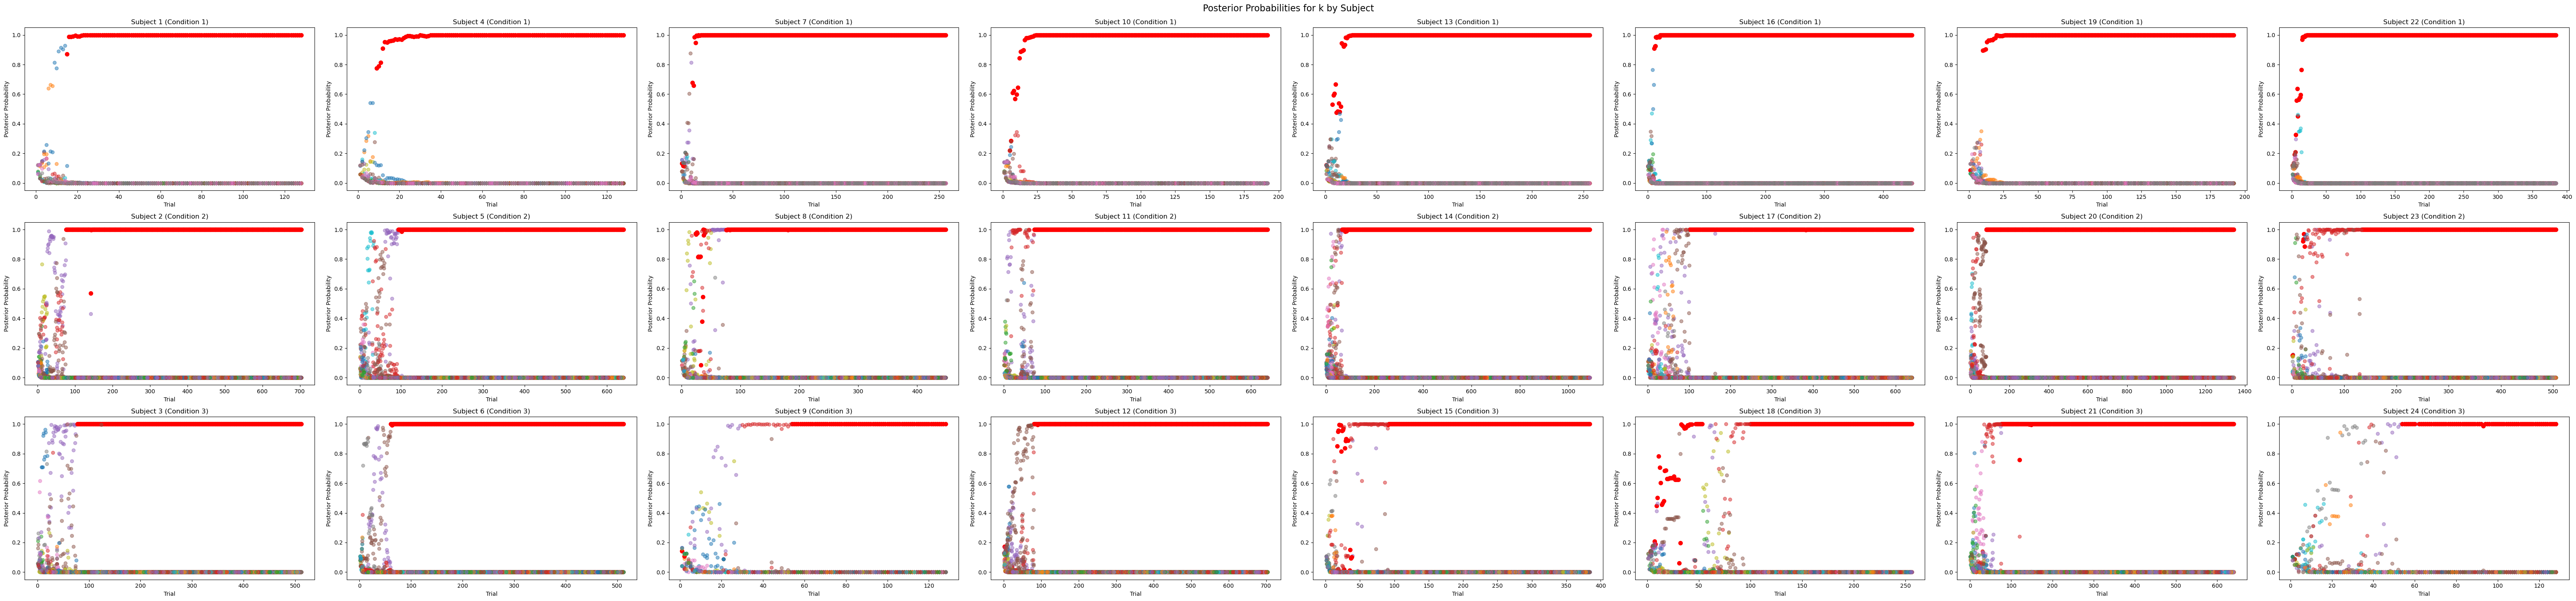

In [73]:
# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Fgt_400_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Fgt_400_posteriors.png')

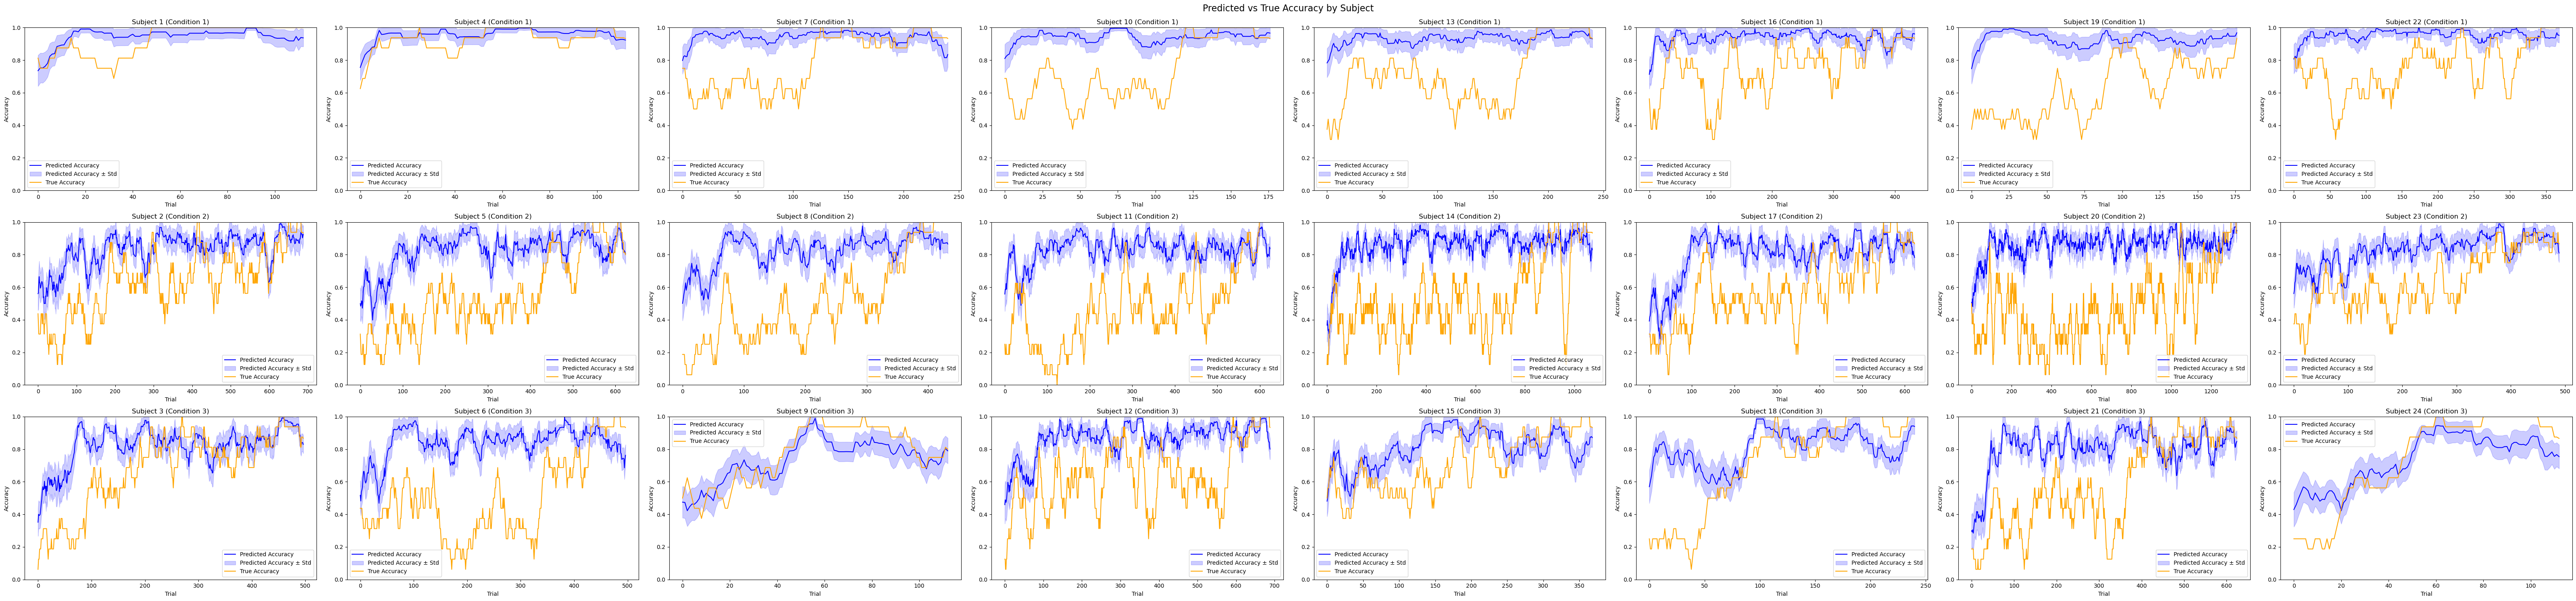

In [74]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_Fgt_400_acc.png')

In [75]:
# 绘制error grid图
model_eval.plot_error_grids(fitting_results, result_path / f'M_Fgt_400_errors.png')